In [58]:
import pickle
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
from sklearn.model_selection import train_test_split
import torch

In [64]:
seed = 761
torch.manual_seed(seed)

In [111]:
with open("hw3-q2.pkl", 'rb') as f:
    data = pickle.load(f)
    
train_dataset = data['train']
val_dataset = data['test']

print("Train size:", len(train_dataset))
print("Validation size:", len(val_dataset))

dim = train_dataset[0].shape[0]
print("dim =", dim)

Train size: 65931
Validation size: 26032
dim = 32


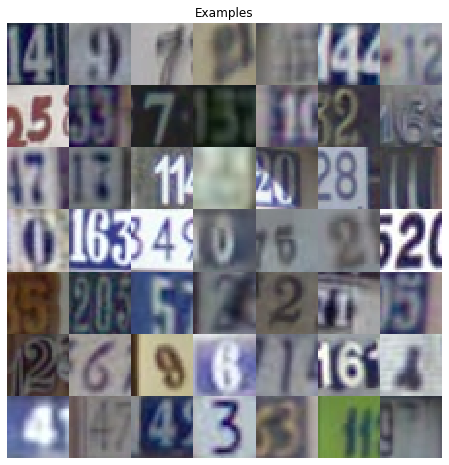

In [112]:
ind = 0
num_elems = 7
rgb = 3

examples = np.zeros((dim * num_elems, num_elems * dim, rgb))

for i in range(num_elems):
    for j in range(num_elems):
        examples[i * dim : (i + 1) * dim, j * dim : (j + 1) * dim, ] = train_dataset[ind] / 255
        ind += 1

plt.figure(figsize=(8, 8))
plt.axis('off')
plt.imshow(examples)
plt.title('Examples')
plt.show()

In [106]:
EPS = 1e-5

In [107]:
class gated_shortcut_connection(nn.Module):
    def __init__(self, channels=16):
        super(gated_shortcut_connection, self).__init__()
        self.channels = channels

        self.c1 = nn.Conv2d(self.channels, self.channels, 1, stride=1, padding=0)
        self.c2 = nn.Conv2d(self.channels, self.channels, 1, stride=1, padding=0)

    def forward(self,x):
        c1 = self.c1(x)
        c2 = self.c1(x)
        return torch.mul(c1, torch.sigmoid(c2 + EPS))

In [108]:
class Residual_stack(nn.Module):
    def __init__(self, channels=64):
        super(Residual_stack, self).__init__()
        self.layers = []
        
        for _ in range(5):
            self.layers.append(nn.ReLU())
            self.layers.append(nn.Conv2d(4 * channels, channels, 3, stride=1, padding=1))
            self.layers.append(nn.ReLU())
            self.layers.append(nn.Conv2d(channels, channels * 2, 3, stride=1, padding=1))
            self.layers.append(gated_shortcut_connection(channels = channels * 2))

        self.layers.append(nn.ReLU())
        self.final_layer = nn.Sequential(*self.layers)

    def forward(self,x):
        return self.final_layer(x) + x

In [113]:
class VAENet(nn.Module):
    def __init__(self, channels=64):
        super(VAENet, self).__init__()
        self.channels = channels
        
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 2 * channels, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(2 * channels, 4 * channels, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(4 * channels, 4 * channels, 3, padding=1),
            nn.ReLU(),
            Residual_stack(channels),
        )        
        
        self.decoder = nn.Sequential(
            nn.Conv2d(2 * channels, 4 * channels, 3, padding=1),
            Residual_stack(channels),
            nn.ConvTranspose2d(2 * channels, 2 * channels, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(2 * channels, 6, 4, stride=2, padding=1)
        )
    
    def encode(self, x):
        x = self.encoder(x).reshape(-1, 2, 2 * self.channels, 8, 8)
        mu = x[:, 0]
        var = torch.exp(x[:, 1])
        z = self.reparam(mu, var)
        return mu, var, z
    
    def decode(self, z):
        x = self.decoder(z)
        x = x.reshape(-1, 2, 3, 32, 32)
        mu = x[:, 0]
        var = torch.exp(x[:, 1])
        return mu, var
    
    def reparam(self, mu, var):
        eps = torch.randn_like(mu, device=device)
        z = mu + eps * torch.sqrt(var)
        return z
            
    def forward(self, x):
        mu_z, var_z, z = self.encode(x)
        mu_x, var_x = self.decode(z)
        return (mu_z, var_z), mu_x, var_x

def loss_func(self, mu, var, x):
    prob = -(torch.log(2 * np.pi * var) + (x - mu) ** 2 / var) / 2
    return -prob.mean()

In [110]:
NUM_EPOCHS = 80
LR = 1e-3
BATCH_SIZE = 1024

In [117]:
model = VAENet()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE)

for epoch in range(NUM_EPOCHS):
    for batch in train_loader:        
        out = model(batch.cuda())
        data, mu_x, var_x = out
            
        loss = loss_func(mu_x, var_x, xs)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()